In [1]:
import numpy as np
import matplotlib.pyplot as plt
from alma import *
import mpmath as mp
from time import time

In [2]:
def get_timer(st=None):
    if st is not None:
        print('Elapsed time: {}s'.format(np.round(time() - st, 2)))
        return
    else:
        return time()

In [3]:
# Initialize
ndigits = 128
Gnwt, iota = initialize(ndigits)

### Tidal deformation of Enceladus

Here I set up some models of tidal deformation of Enceladus following Beuthe 2018. I assume:
* a uniform, elastic inner core
* a global ocean
* an icy shell

Some general parameters:

In [4]:
a = 252e3     # radius
c = 192e3     # core radius

rho_i = 930   # ice density
rho_w = 1020  # water density
rho_b = 1610  # bulk density

mu_i  = 3.5e9 # ice rigidity
mu_c  = 40e9  # core rigidity

eta_w = 1e4   # water viscosity

eta_m = 1e13  # basal ice viscosity

Tm = 273      # basal temperature
Ts = 59       # surface temperature

Ea = 59.4e3   # Activation energy (J/mol)
Rg = 8.314    # gas constant (J/(mol*K))

omega = 5.307e-5   # Rotation rate (s**-1)

mass      = rho_b * (4/3) * np.pi * a**3     # Mass (kg)

Forcing period

In [5]:
t_sec  = 2*np.pi/omega
t_days = t_sec / (24*60*60)
t_kyr  = t_days / (365.25 * 1000)

Range of ice thicknesses

In [6]:
h_ice = np.arange(10, 51, 1) * 1000

Some general parameters for ALMA

In [7]:
n = 2
loadtype='tidal'
loadfcn='step'
tau=0
order=8

I. Elastic LNs as a function of the shell thickness (to be compared with FIG1 of Beuthe 2018)

SERIAL

In [8]:
st = get_timer()

h_ela = np.zeros( len(h_ice), dtype=float )
l_ela = np.zeros( len(h_ice), dtype=float )
k_ela = np.zeros( len(h_ice), dtype=float )

output='real'

t_elastic = 1e-9

for i in range(len(h_ice)):
    h       = h_ice[i]
    rb      = a - h
    mass_ice   = 4/3 * np.pi * (a**3 - rb**3) * rho_i
    mass_ocean = 4/3 * np.pi * (rb**3 - c**3) * rho_w
    mass_core = mass - mass_ice - mass_ocean
    rho_c     = mass_core / (4/3 * np.pi * c**3) 
    r       = np.array([c, rb, a])
    rho     = np.array([rho_c, rho_w, rho_i])
    mu      = np.array([mu_c,  0,     mu_i] )
    eta     = np.array([1e99, eta_w,  eta_m])
    rheology= ['elastic', 'newton', 'maxwell']
    par     = np.zeros( (3,2) )
    model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=ndigits,verbose=False)
    hh, ll, kk = love_numbers([ n ],[ t_elastic ],loadtype,loadfcn,tau,model_params,output,order,verbose=False)
    h_ela[i] = hh[0,0]
    l_ela[i] = ll[0,0]
    k_ela[i] = kk[0,0]

get_timer(st)

Elapsed time: 2.42s


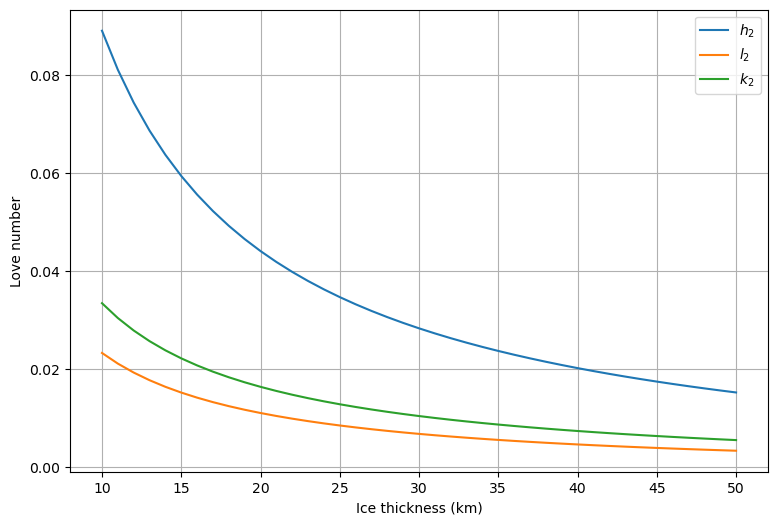

In [9]:
plt.figure( figsize=(9,6) )
plt.plot( h_ice/1000, h_ela, linestyle='-',  label='$h_2$'   )
plt.plot( h_ice/1000, l_ela, linestyle='-',  label='$l_2$'   )
plt.plot( h_ice/1000, k_ela, linestyle='-',  label='$k_2$'   )
plt.legend()
plt.grid()
plt.xlabel('Ice thickness (km)')
plt.ylabel('Love number');

PARALLEL

In [10]:
st = get_timer()

h_ela = np.zeros( len(h_ice), dtype=float )
l_ela = np.zeros( len(h_ice), dtype=float )
k_ela = np.zeros( len(h_ice), dtype=float )

output='real'

t_elastic = 1e-9

for i in range(len(h_ice)):
    h       = h_ice[i]
    rb      = a - h
    mass_ice   = 4/3 * np.pi * (a**3 - rb**3) * rho_i
    mass_ocean = 4/3 * np.pi * (rb**3 - c**3) * rho_w
    mass_core = mass - mass_ice - mass_ocean
    rho_c     = mass_core / (4/3 * np.pi * c**3) 
    r       = np.array([c, rb, a])
    rho     = np.array([rho_c, rho_w, rho_i])
    mu      = np.array([mu_c,  0,     mu_i] )
    eta     = np.array([1e99, eta_w,  eta_m])
    rheology= ['elastic', 'newton', 'maxwell']
    par     = np.zeros( (3,2) )
    model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=ndigits,verbose=False)
    hh, ll, kk = love_numbers([ n ],[ t_elastic ],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=True)
    h_ela[i] = hh[0,0]
    l_ela[i] = ll[0,0]
    k_ela[i] = kk[0,0]

get_timer(st)

Elapsed time: 5.76s


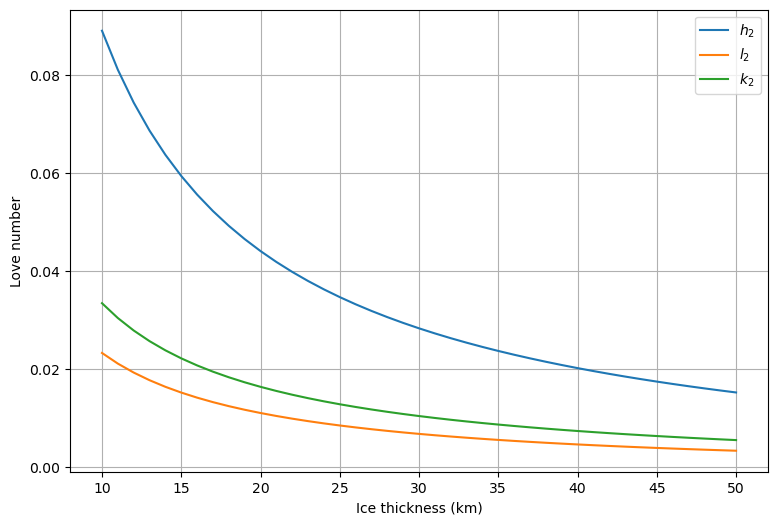

In [11]:
plt.figure( figsize=(9,6) )
plt.plot( h_ice/1000, h_ela, linestyle='-',  label='$h_2$'   )
plt.plot( h_ice/1000, l_ela, linestyle='-',  label='$l_2$'   )
plt.plot( h_ice/1000, k_ela, linestyle='-',  label='$k_2$'   )
plt.legend()
plt.grid()
plt.xlabel('Ice thickness (km)')
plt.ylabel('Love number');

II. Viscoelastic LNs for a layered ice shell

Now I assume a temperature-dependent viscosity profile in the ice shell according to the Arrhenius law

$$ \eta = \eta_m \exp\left( \frac{E_a}{R_g T_m} \left[\frac{T_m}{T}-1\right) \right] $$

where $\eta_m$ is the ice melt viscosity, $R_g$ is the gas constant and $E_a = 59.4$ kJ/mol is the activation energy.

I assume that the base of the lithosphere has a basal temperature $T_m = 273K$ (to be in equilibrium with the liquid ocean) and that the surface has an average temperature $T_s = 59K$. The temperature $T$ inside the ice shell is assumed to scale with radius $r$ as

$$ T(r) = T_m^{(r-a)/(r_b-a)}  T_s^{(r_b-r)/(r_b-a)} $$

For a given ice shell thickness I create an onion-like structure with layers of constant thickness $\Delta$ and assign to each layer a viscosity given by the above equations.

SERIAL

In [12]:
st = get_timer()

delta = 500        # Layer size (m)

h_enc = np.zeros( len(h_ice), dtype=complex )
l_enc = np.zeros( len(h_ice), dtype=complex )
k_enc = np.zeros( len(h_ice), dtype=complex )

output='complex'

for i in range(len(h_ice)):
    h       = h_ice[i]
    rb      = a - h
    mass_ice   = 4/3 * np.pi * (a**3 - rb**3) * rho_i
    mass_ocean = 4/3 * np.pi * (rb**3 - c**3) * rho_w
    mass_core = mass - mass_ice - mass_ocean
    rho_c     = mass_core / (4/3 * np.pi * c**3) 
    n_ice   = int(round( h/delta ))
    r_ice   = np.linspace(rb,a,n_ice+1)
    x       = r_ice[:-1] + delta/2
    T       = Tm**( (x-a)/(rb-a) ) * Ts**( (rb-x) / (rb-a) )
    eta_ice = eta_m * np.exp( Ea / (Rg * Tm) * (Tm/T - 1) )
    r       = np.insert(r_ice,0,c)
    eta     = np.concatenate([ np.array([1e40, eta_w]) , eta_ice ])
    rho     = np.concatenate([ np.array([rho_c, rho_w]) , np.repeat(rho_i, n_ice) ])
    mu      = np.concatenate([ np.array([mu_c,  0.0])   , np.repeat(mu_i,  n_ice) ])
    rheology= [ 'elastic', 'newton' ] + [ 'maxwell' for j in range(n_ice) ]
    par     = np.zeros( (n_ice+2, 2) )
    model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=ndigits,verbose=False)
    hh, ll, kk = love_numbers([ n ],[ t_kyr ],loadtype,loadfcn,tau,model_params,output,order,verbose=False)
    h_enc[i] = hh[0,0]
    l_enc[i] = ll[0,0]
    k_enc[i] = kk[0,0]

get_timer(st)

Elapsed time: 9.58s


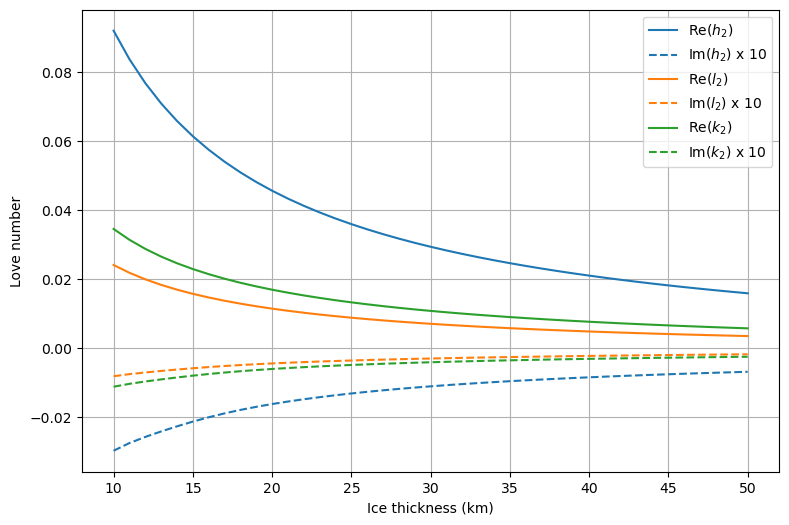

In [13]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure( figsize=(9,6) )

plt.plot(h_ice/1000, np.real(h_enc),    color=colors[0], label='Re($h_2$)' )
plt.plot(h_ice/1000, np.imag(h_enc)*10, color=colors[0], linestyle='--', label='Im($h_2$) x 10' )
plt.plot(h_ice/1000, np.real(l_enc),    color=colors[1], label='Re($l_2$)' )
plt.plot(h_ice/1000, np.imag(l_enc)*10, color=colors[1], linestyle='--', label='Im($l_2$) x 10' )
plt.plot(h_ice/1000, np.real(k_enc),    color=colors[2], label='Re($k_2$)' )
plt.plot(h_ice/1000, np.imag(k_enc)*10, color=colors[2], linestyle='--', label='Im($k_2$) x 10' )

plt.grid()
plt.xlabel('Ice thickness (km)')
plt.ylabel('Love number')
plt.legend()


PARALLEL

In [14]:
st = get_timer()

delta = 500        # Layer size (m)

h_enc = np.zeros( len(h_ice), dtype=complex )
l_enc = np.zeros( len(h_ice), dtype=complex )
k_enc = np.zeros( len(h_ice), dtype=complex )

output='complex'

for i in range(len(h_ice)):
    h       = h_ice[i]
    rb      = a - h
    mass_ice   = 4/3 * np.pi * (a**3 - rb**3) * rho_i
    mass_ocean = 4/3 * np.pi * (rb**3 - c**3) * rho_w
    mass_core = mass - mass_ice - mass_ocean
    rho_c     = mass_core / (4/3 * np.pi * c**3) 
    n_ice   = int(round( h/delta ))
    r_ice   = np.linspace(rb,a,n_ice+1)
    x       = r_ice[:-1] + delta/2
    T       = Tm**( (x-a)/(rb-a) ) * Ts**( (rb-x) / (rb-a) )
    eta_ice = eta_m * np.exp( Ea / (Rg * Tm) * (Tm/T - 1) )
    r       = np.insert(r_ice,0,c)
    eta     = np.concatenate([ np.array([1e40, eta_w]) , eta_ice ])
    rho     = np.concatenate([ np.array([rho_c, rho_w]) , np.repeat(rho_i, n_ice) ])
    mu      = np.concatenate([ np.array([mu_c,  0.0])   , np.repeat(mu_i,  n_ice) ])
    rheology= [ 'elastic', 'newton' ] + [ 'maxwell' for j in range(n_ice) ]
    par     = np.zeros( (n_ice+2, 2) )
    model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=ndigits,verbose=False)
    hh, ll, kk = love_numbers([ n ],[ t_kyr ],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=True)
    h_enc[i] = hh[0,0]
    l_enc[i] = ll[0,0]
    k_enc[i] = kk[0,0]

get_timer(st)

Elapsed time: 12.24s


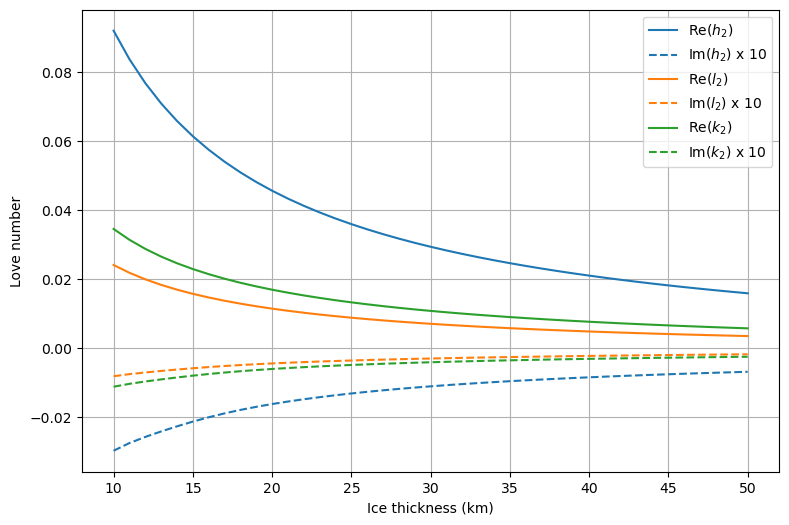

In [15]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure( figsize=(9,6) )

plt.plot(h_ice/1000, np.real(h_enc),    color=colors[0], label='Re($h_2$)' )
plt.plot(h_ice/1000, np.imag(h_enc)*10, color=colors[0], linestyle='--', label='Im($h_2$) x 10' )
plt.plot(h_ice/1000, np.real(l_enc),    color=colors[1], label='Re($l_2$)' )
plt.plot(h_ice/1000, np.imag(l_enc)*10, color=colors[1], linestyle='--', label='Im($l_2$) x 10' )
plt.plot(h_ice/1000, np.real(k_enc),    color=colors[2], label='Re($k_2$)' )
plt.plot(h_ice/1000, np.imag(k_enc)*10, color=colors[2], linestyle='--', label='Im($k_2$) x 10' )

plt.grid()
plt.xlabel('Ice thickness (km)')
plt.ylabel('Love number')
plt.legend()


### Loading Love Numbers for a transient Earth model

Here I compute loading Love Numbers and their derivatives for the VM5a model.

The $h_n(t)$ LLN is computed for $n=2,10,100$ as a function of time $t$. The standard VM5a model, based on a Maxwell rheology, is compared with transient models in which for the upper mantle a Burgers (VM5a-BG) or Andrade (VM5a-AD) rheology is assumed.

In [16]:
# VM5a Earth model

r   = np.array( [ 3485.5, 5111.0, 5701.0 , 6271.0, 6311.0, 6371.0 ] ) * 1000
rho = np.array( [ 1.09626e4, 5.10252e3, 4.54824e3, 3.63687e3, 3.37472e3, 3.02751e3] )
mu  = np.array( [ 0, 2.4446e11, 1.8321e11, 8.9212e10, 6.7446e10, 5.2429e10 ] )
eta = np.array( [ 0, 3.23e21, 1.57e21, 5e20, 1e22, 1e99 ] )


In [17]:
# Time steps

t = np.logspace(-3,2,101)

In [18]:
# Harmonic degrees

n = [2, 10, 100]

In [19]:
# Other parameters

loadtype='loading'
loadfcn='step'
tau=0
order=8

SERIAL

In [20]:
# Compute LLN

output='real'

# Maxwell UM
print( 'VM5a model')

rheology = [ 'fluid', 'maxwell', 'maxwell', 'maxwell', 'maxwell', 'elastic' ]
par = np.zeros( (len(r),2) )

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True)
hMX, lMX, kMX = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

# Burgers UM
print( 'VM5a-BG model' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'burgers', 'burgers', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [1, 0.1]
par[4,:] = [1, 0.1]

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True)
hBG, lBG, kBG = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

# Andrade UM
print( 'VM5a-AD model' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'andrade', 'andrade', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [0.3, 0]
par[4,:] = [0.3, 0]

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True)
hAD, lAD, kAD = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

VM5a model
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Serial
   >> processing 1 of 3
Harmonic degree n = 2 (11.24 s)
   >> processing 2 of 3
Harmonic degree n = 10 (11.84 s)
   >> processing 3 of 3
Harmonic degree n = 100 (12.6 s)
Elapsed time: 35.68s
VM5a-BG model
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Serial
   >> processing 1 of 3
Harmonic degree n = 2 (11.41 s)
   >> processing 2 of 3
Harmonic degree n = 10 (11.97 s)
   >> processing 3 of 3
Harmonic degree n = 100 (12.53 s)
Elapsed time: 35.91s
VM5a-AD model
> Initializing
  >> Setting precision: 128
> Building 

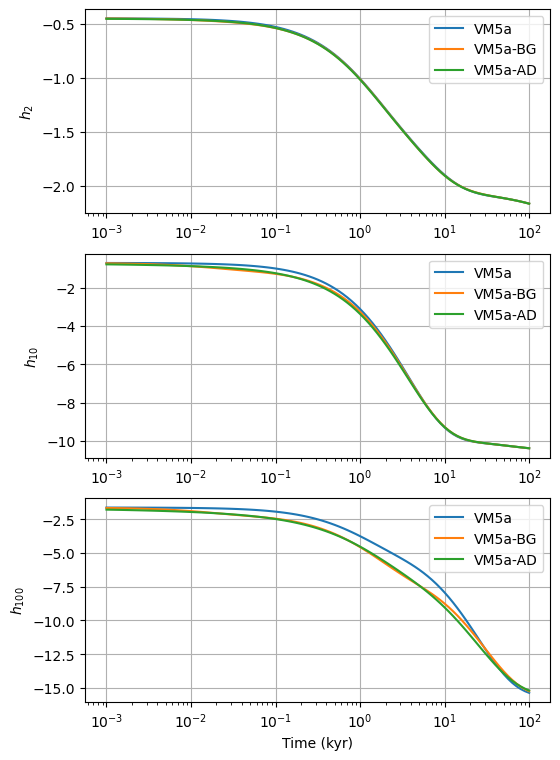

In [21]:
fig, ax = plt.subplots(3, figsize=(6,9))

for i in range(3):
    ax[i].semilogx(t, hMX[i,:], label='VM5a')
    ax[i].semilogx(t, hBG[i,:], label='VM5a-BG')
    ax[i].semilogx(t, hAD[i,:], label='VM5a-AD')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_ylabel('$h_{'+str(n[i])+'}$')

ax[0].legend()
ax[2].set_xlabel('Time (kyr)');

PARALLEL

In [22]:
# Compute LLN
output='real'

# Maxwell UM
print( 'VM5a model')
rheology = [ 'fluid', 'maxwell', 'maxwell', 'maxwell', 'maxwell', 'elastic' ]
par = np.zeros( (len(r),2) )

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True, parallel=True)
hMX, lMX, kMX = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

# Burgers UM
print( 'VM5a-BG model' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'burgers', 'burgers', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [1, 0.1]
par[4,:] = [1, 0.1]

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True, parallel=True)
hBG, lBG, kBG = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

# Andrade UM
print( 'VM5a-AD model' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'andrade', 'andrade', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [0.3, 0]
par[4,:] = [0.3, 0]

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128, verbose=True, parallel=True)
hAD, lAD, kAD = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

VM5a model
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


  >> Clearing spawned threads.
Elapsed time: 44.09s
VM5a-BG model
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


  >> Clearing spawned threads.
Elapsed time: 44.55s
VM5a-AD model
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel
  >> Clearing spawned threads.
Elapsed time: 42.96s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.9s finished


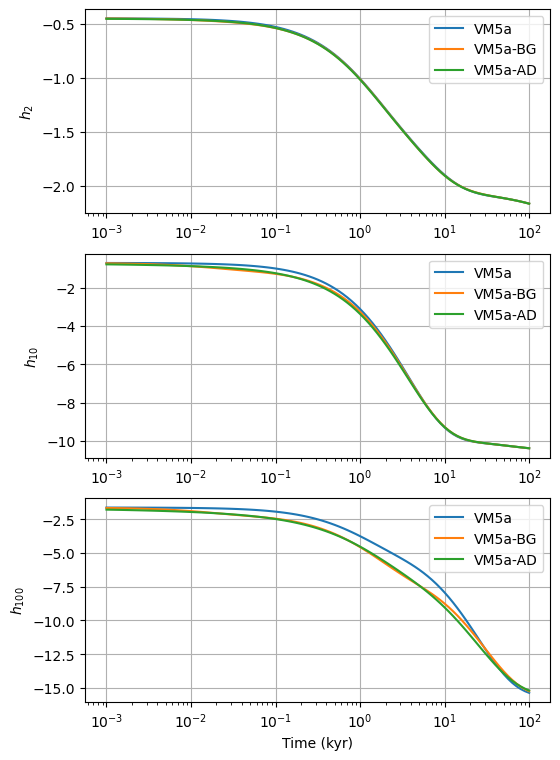

In [23]:
fig, ax = plt.subplots(3, figsize=(6,9))

for i in range(3):
    ax[i].semilogx(t, hMX[i,:], label='VM5a')
    ax[i].semilogx(t, hBG[i,:], label='VM5a-BG')
    ax[i].semilogx(t, hAD[i,:], label='VM5a-AD')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_ylabel('$h_{'+str(n[i])+'}$')

ax[0].legend()
ax[2].set_xlabel('Time (kyr)');

SERIAL

In [ ]:
# Compute derivatives of LLN

output='rate'

# Maxwell UM
print( 'VM5a' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'maxwell', 'maxwell', 'elastic' ]
par = np.zeros( (len(r),2) )

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True)
dhMX, dlMX, dkMX = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

# Burgers UM
print( 'VM5a-BG' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'burgers', 'burgers', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [1, 0.1]
par[4,:] = [1, 0.1]

st = get_timer()
model_params=build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True)
dhBG, dlBG, dkBG = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

# Andrade UM
print( 'VM5a-AD' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'andrade', 'andrade', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [0.3, 0]
par[4,:] = [0.3, 0]

st = get_timer()
model_params=build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True)
dhAD, dlAD, dkAD = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=False)
get_timer(st)

VM5a
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Serial
   >> processing 1 of 3
Harmonic degree n = 2 (11.38 s)
   >> processing 2 of 3
Harmonic degree n = 10 (11.94 s)
   >> processing 3 of 3
Harmonic degree n = 100 (12.6 s)
Elapsed time: 35.92s
VM5a-BG
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Serial
   >> processing 1 of 3
Harmonic degree n = 2 (11.29 s)
   >> processing 2 of 3
Harmonic degree n = 10 (12.04 s)
   >> processing 3 of 3
Harmonic degree n = 100 (12.81 s)
Elapsed time: 36.14s
VM5a-AD
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing

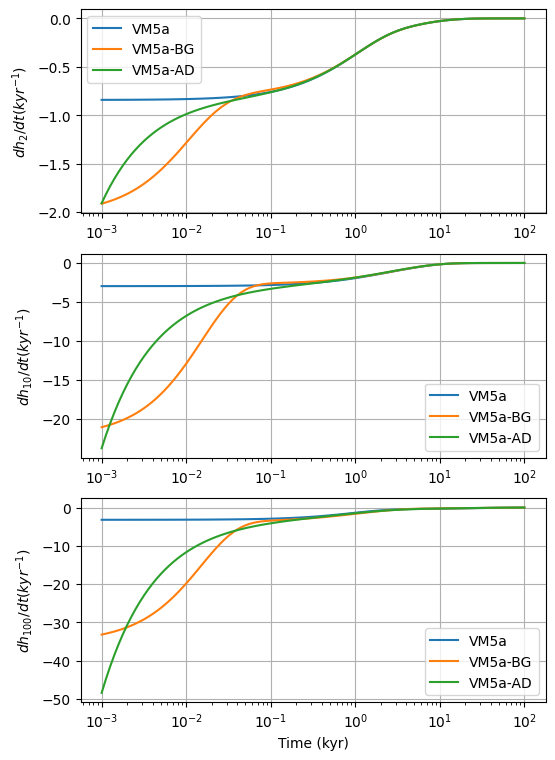

In [ ]:
fig, ax = plt.subplots(3, figsize=(6,9))

for i in range(3):
    ax[i].semilogx(t, dhMX[i,:], label='VM5a')
    ax[i].semilogx(t, dhBG[i,:], label='VM5a-BG')
    ax[i].semilogx(t, dhAD[i,:], label='VM5a-AD')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_ylabel('$dh_{'+str(n[i])+'}/dt (kyr^{-1})$')

ax[0].legend()
ax[2].set_xlabel('Time (kyr)');

PARALLEL

In [ ]:
# Compute derivatives of LLN

output='rate'

# Maxwell UM
print( 'VM5a' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'maxwell', 'maxwell', 'elastic' ]
par = np.zeros( (len(r),2) )

st = get_timer()
model_params = build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True, parallel=True)
dhMX, dlMX, dkMX = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

# Burgers UM
print( 'VM5a-BG' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'burgers', 'burgers', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [1, 0.1]
par[4,:] = [1, 0.1]

st = get_timer()
model_params=build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True, parallel=True)
dhBG, dlBG, dkBG = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

# Andrade UM
print( 'VM5a-AD' )
rheology = [ 'fluid', 'maxwell', 'maxwell', 'andrade', 'andrade', 'elastic' ]
par = np.zeros( (len(r),2) )
par[3,:] = [0.3, 0]
par[4,:] = [0.3, 0]

st = get_timer()
model_params=build_model(r,rho,mu,eta,rheology,par,ndigits=128,verbose=True, parallel=True)
dhAD, dlAD, dkAD = love_numbers(n,t,loadtype,loadfcn,tau,model_params,output,order,verbose=True, parallel=True)
get_timer(st)

VM5a
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


  >> Clearing spawned threads.
Elapsed time: 17.44s
VM5a-BG
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


  >> Clearing spawned threads.
Elapsed time: 17.46s
VM5a-AD
> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters
> Computing Salzer weights
> Computing Love Numbers - Parallel
  >> Clearing spawned threads.
Elapsed time: 18.05s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.0s finished


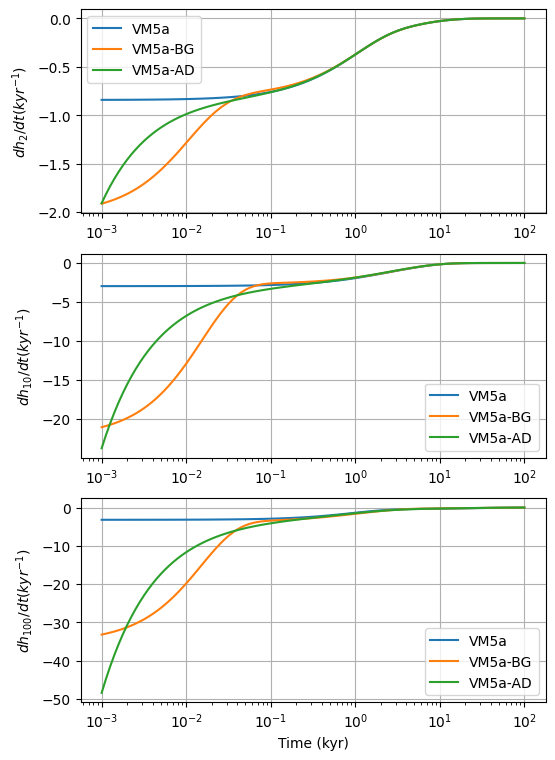

In [ ]:
fig, ax = plt.subplots(3, figsize=(6,9))

for i in range(3):
    ax[i].semilogx(t, dhMX[i,:], label='VM5a')
    ax[i].semilogx(t, dhBG[i,:], label='VM5a-BG')
    ax[i].semilogx(t, dhAD[i,:], label='VM5a-AD')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_ylabel('$dh_{'+str(n[i])+'}/dt (kyr^{-1})$')

ax[0].legend()
ax[2].set_xlabel('Time (kyr)');

### Tidal dissipation of the Moon

In [ ]:
# Load the Weber2011 model

data = np.loadtxt( 'DATA/Moon_Weber11.dat', comments='#', encoding='utf-8' )

a     = 1737.1
depth = data[:,0]
r     = a - depth
vp    = data[:,1] * 1000
vs    = data[:,2] * 1000
rho   = data[:,3] * 1000
mu    = rho * vs**2

r_w11   = r[0::2]
rho_w11 = rho[0::2]
mu_w11  = mu[0::2]

r_w11   = np.flipud( r_w11 )
rho_w11 = np.flipud( rho_w11 )
mu_w11  = np.flipud( mu_w11 )

In [ ]:
# Load the Garcia2012 model

data = np.loadtxt( 'DATA/Moon_Garcia12.dat', comments='#' )

r     = data[:,0]
vp    = data[:,1] * 1000
vs    = data[:,2] * 1000
rho   = data[:,3] * 1000
mu    = rho * vs**2

nla   = len(r)

idx     = np.array([1,3,5] + list(range(7,nla-3+1)) + [nla - 1]) - 1
r_g12   = r[idx]
rho_g12 = rho[idx]
mu_g12  = mu[idx]

r_g12   = np.flipud( r_g12 )
rho_g12 = np.flipud( rho_g12 )
mu_g12  = np.flipud( mu_g12 )


In [ ]:
# Identify the layers

#0--> Inner core
#1--> Core
#2--> LVZ
#3--> Mantle
#4--> Crust

# For Weber 2011

layertype_w11 = np.zeros( len(r_w11), dtype=int )
r=r_w11
layertype_w11[ (r<=240)             ] = 0
layertype_w11[ (r>240 ) & (r<=330 ) ] = 1
layertype_w11[ (r>330 ) & (r<=480 ) ] = 2
layertype_w11[ (r>480 ) & (r<=1700) ] = 3
layertype_w11[ (r>1700)             ] = 4

# For Garcia 2012

layertype_g12 = np.zeros( len(r_g12), dtype=int )

r=r_g12
layertype_g12[ r<=380 ]                        = 1
layertype_g12[ (r>380)       &  (r<=380+150) ] = 2
layertype_g12[ (r>=380+150)  &  (r<1700)     ] = 3
layertype_g12[ r>1700                        ] = 4



In [ ]:
# Define the rheology and viscosity for each layer class

rheology = [  'maxwell', 'newton', 'maxwell', 'maxwell', 'maxwell' ]
eta      = [   1e16, 1e4, -1, 1e20, 1e20 ]

# -1 is a placeholder for the LVZ viscosity which will be varied 

In [ ]:
reol_w11 = []
eta_w11  = np.zeros(len(r_w11))

for i in range(len(r_w11)):
    itype = layertype_w11[i]
    reol_w11.append(rheology[itype])
    eta_w11[i] = eta[itype] 

reol_g12 = []
eta_g12  = np.zeros(len(r_g12))

for i in range(len(r_g12)):
    itype = layertype_g12[i]
    reol_g12.append(rheology[itype])
    eta_g12[i] = eta[itype] 


Text(0.5, 0, 'r (km)')

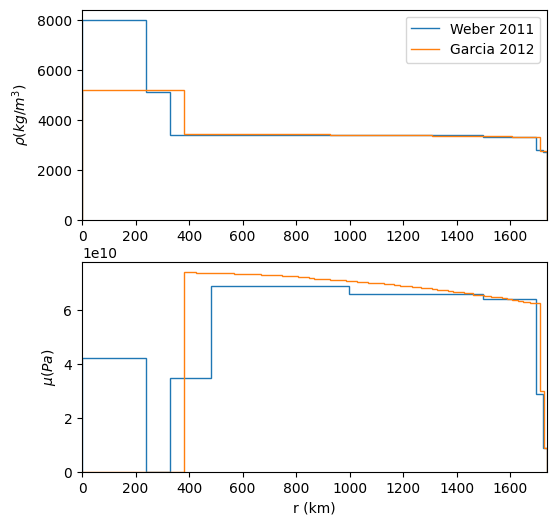

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6,6))

ax1.stairs(rho_w11, edges=np.append( np.zeros(1), r_w11), label='Weber 2011' )
ax1.stairs(rho_g12, edges=np.append( np.zeros(1), r_g12), label='Garcia 2012' )
ax1.set_xlim(0,1737)
ax1.set_ylabel('$\\rho (kg/m^3)$')
ax1.legend()

ax2.stairs(mu_w11, edges=np.append( np.zeros(1), r_w11) )
ax2.stairs(mu_g12, edges=np.append( np.zeros(1), r_g12) )
ax2.set_xlim(0,1737)
ax2.set_ylabel('$\\mu (Pa)$')
ax2.set_xlabel('r (km)')



In [ ]:
# Range of LVZ viscosities

log_eta_lvz = np.arange(14,18.01,0.05)

In [ ]:
# Forcing period

t = 27.212     # days
t = t / (365.25 * 1000)   #kyr

In [ ]:
# ALMA parameters

n = 2
loadtype='tidal'
loadfcn='step'
tau=0
output='complex'
order=8


SERIAL

In [ ]:
# Weber2011-based models

kw11 = np.zeros( len(log_eta_lvz), dtype=complex )
par  = np.zeros( ( len(r_w11), 2 ) )
st = get_timer()
for i in range( len(log_eta_lvz) ):
    eta_lvz = 10**log_eta_lvz[i]
    visco   = np.copy(eta_w11)
    visco[eta_w11<0] = eta_lvz
    
    
    model_params = build_model(r_w11*1000,rho_w11,mu_w11,visco,reol_w11,par,ndigits=128,verbose=False)
    hh, ll, kk = love_numbers([n],[t],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=False)
    kw11[i] = kk[0,0]
get_timer(st)

# Garcia2012-based models

kg12 = np.zeros( len(log_eta_lvz), dtype=complex )
par  = np.zeros( ( len(r_g12), 2 ) )
st = get_timer()
for i in range( len(log_eta_lvz) ):
    eta_lvz = 10**log_eta_lvz[i]
    visco   = np.copy(eta_g12)
    visco[eta_g12<0] = eta_lvz
    
    
    model_params = build_model(r_g12*1000,rho_g12,mu_g12,visco,reol_g12,par,ndigits=128,verbose=False)
    hh, ll, kk = love_numbers([n],[t],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=False)
    kg12[i] = kk[0,0]
get_timer(st)



Elapsed time: 0.98s
Elapsed time: 7.7s


PARALLEL

In [ ]:
# Weber2011-based models

kw11 = np.zeros( len(log_eta_lvz), dtype=complex )
par  = np.zeros( ( len(r_w11), 2 ) )
st = get_timer()
for i in range( len(log_eta_lvz) ):
    eta_lvz = 10**log_eta_lvz[i]
    visco   = np.copy(eta_w11)
    visco[eta_w11<0] = eta_lvz
    
    
    model_params = build_model(r_w11*1000,rho_w11,mu_w11,visco,reol_w11,par,ndigits=128,verbose=False, parallel=True)
    hh, ll, kk = love_numbers([n],[t],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=True)
    kw11[i] = kk[0,0]
get_timer(st)

# Garcia2012-based models

kg12 = np.zeros( len(log_eta_lvz), dtype=complex )
par  = np.zeros( ( len(r_g12), 2 ) )
st = get_timer()
for i in range( len(log_eta_lvz) ):
    eta_lvz = 10**log_eta_lvz[i]
    visco   = np.copy(eta_g12)
    visco[eta_g12<0] = eta_lvz
    
    model_params = build_model(r_g12*1000,rho_g12,mu_g12,visco,reol_g12,par,ndigits=128,verbose=False, parallel=True)
    hh, ll, kk = love_numbers([n],[t],loadtype,loadfcn,tau,model_params,output,order,verbose=False, parallel=True)
    kg12[i] = kk[0,0]
get_timer(st)


Elapsed time: 2.93s
Elapsed time: 8.94s


In [ ]:
k2abs_w11 = np.abs(kw11)
phi_w11   = -np.arctan(np.imag(kw11)/np.real(kw11))
q_w11     = 1/np.sin(phi_w11)

k2abs_g12 = np.abs(kg12)
phi_g12   = -np.arctan(np.imag(kg12)/np.real(kg12))
q_g12     = 1/np.sin(phi_g12)


Text(0.5, 0, 'LVZ viscosity (Pa s)')

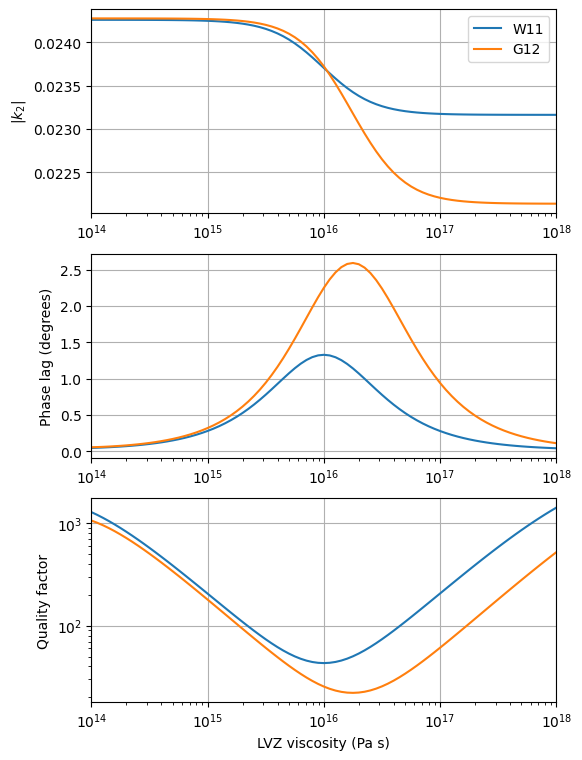

In [ ]:

r2d = 180 / np.pi

fig, (ax1,ax2,ax3) = plt.subplots( 3, figsize=(6,9) )

ax1.semilogx( 10**log_eta_lvz, k2abs_w11, label='W11' )
ax1.semilogx( 10**log_eta_lvz, k2abs_g12, label='G12' )
ax1.set_xlim(1e14, 1e18)
ax1.grid()
ax1.legend()
ax1.set_ylabel('$|k_2|$')

ax2.semilogx( 10**log_eta_lvz, phi_w11*r2d, label='W11' )
ax2.semilogx( 10**log_eta_lvz, phi_g12*r2d, label='G12' )
ax2.set_xlim(1e14, 1e18)
ax2.grid()
ax2.set_ylabel('Phase lag (degrees)')

ax3.loglog( 10**log_eta_lvz, q_w11, label='W11' )
ax3.loglog( 10**log_eta_lvz, q_g12, label='G12' )
ax3.set_xlim(1e14, 1e18)
ax3.grid()
ax3.set_ylabel('Quality factor')
ax3.set_xlabel('LVZ viscosity (Pa s)')

